# Exploration

In [1]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
import seaborn as sns

from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr

import env
import wrangle

## Acquire and Prepare Data

We will use the function we created during our acquire/prep lesson:

In [2]:
def wrangle_grades():
    '''
    Read student_grades csv file into a pandas DataFrame,
    drop student_id column, replace whitespaces with NaN values,
    drop any rows with Null values, convert all columns to int64,
    return cleaned student grades DataFrame.
    '''
    # Acquire data from csv file.
    file = "https://gist.githubusercontent.com/ryanorsinger/14c8f919920e111f53c6d2c3a3af7e70/raw/07f6e8004fa171638d6d599cfbf0513f6f60b9e8/student_grades.csv"

    grades = pd.read_csv(file)

    # Replace white space values with NaN values.
    grades = grades.replace(r'^\s*$', np.nan, regex=True)

    # Drop all rows with NaN values.
    df = grades.dropna()

    # Convert all columns to int64 data types.
    df = df.astype('int')

    return df

In [3]:
df = wrangle_grades()

In [4]:
df.head()

,student_id,exam1,exam2,exam3,final_grade
0,1,100,90,95,96
1,2,98,93,96,95
2,3,85,83,87,87
3,4,83,80,86,85
4,5,93,90,96,97


Is `student_id` unique?

In [5]:
df.student_id.nunique()

102

In [6]:
df.student_id.shape

(102,)

In [7]:
# Does each value unique identify a row?
df.student_id.nunique() == df.student_id.shape[0]

True

In [8]:
df = df.drop(columns='student_id')

In [9]:
train, test = train_test_split(df, random_state=123, train_size=.8)

In [10]:
train.shape, test.shape

((81, 4), (21, 4))

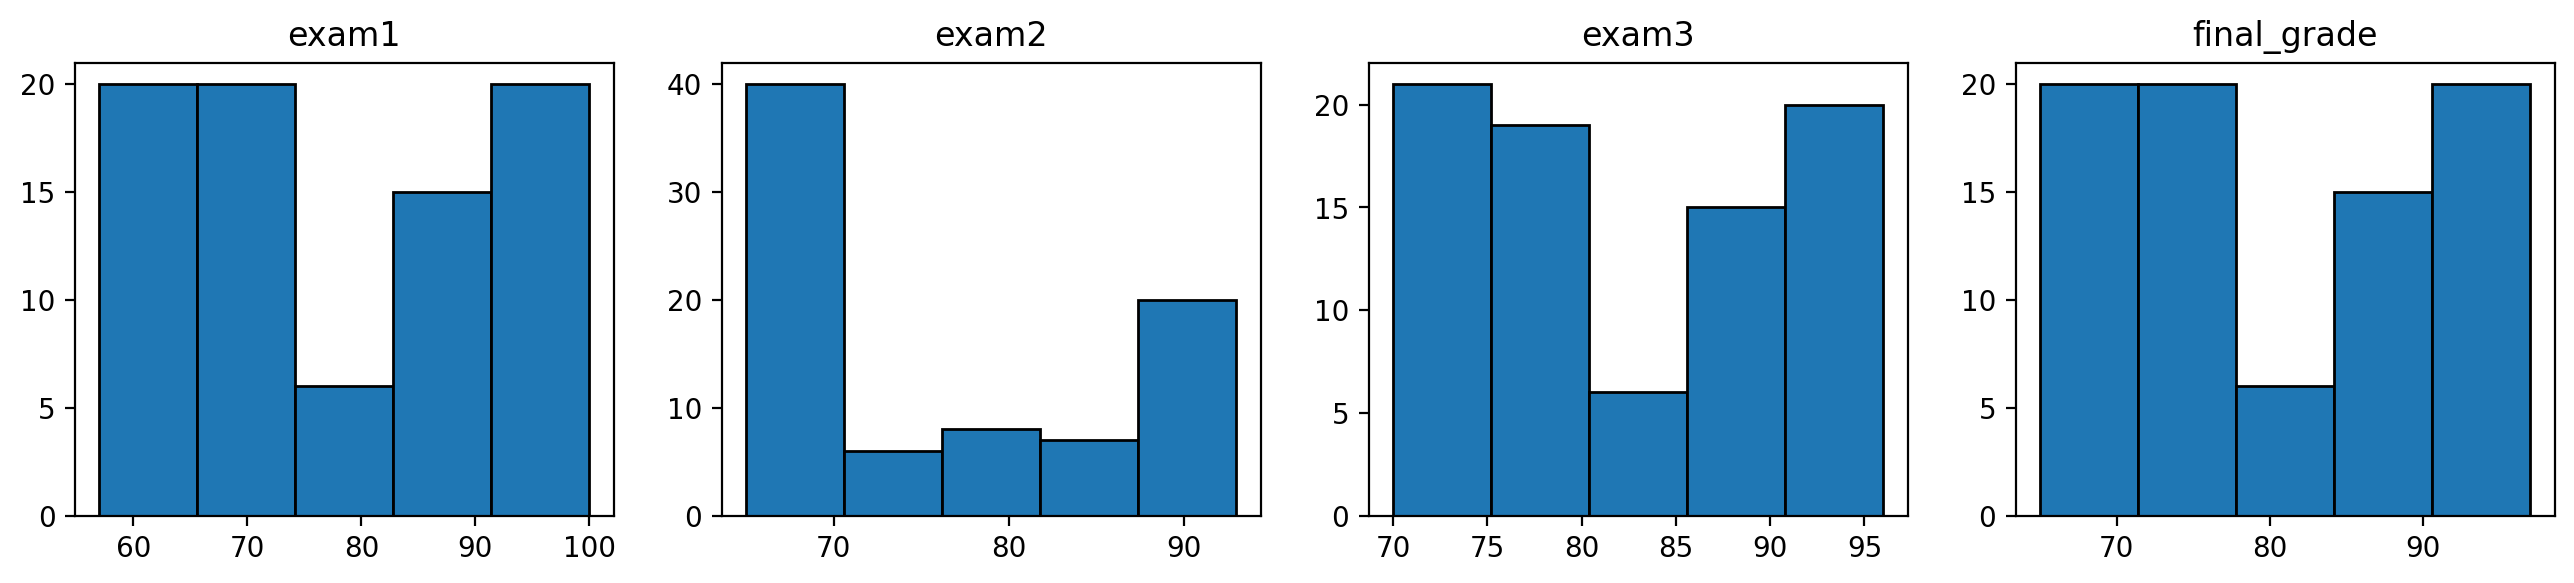

In [11]:
plt.figure(figsize=(16, 3))

for i, col in enumerate(train.columns):
    
    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1
    
    # Create subplot.
    # plt.subplot(row X col, where?)
    plt.subplot(1,4,plot_number)
    
    # Title with column name.
    plt.title(col)
    
    # Display histogram for column.
    train[col].hist(bins=5, edgecolor='black')
    
    # Hide gridlines.
    plt.grid(False)

## Why Explore?

- What is the purpose of this pipeline stage?

## Main Stages in Exploration
- Hypothesize
- Visualize
    - Plot out the distributions of each feature
        - Why?
    - Plot out the interaction of two or more variables?
        - Why?
    - Plot out how subgroups compare to each-other and to the overall population?
        - Why?
    - Document takeaways
        - Why?
    - Identify features that correlate with each other
        - Why?
- Test Hypotheses

---
## Goal

Let's keep our goal from our student grades scenario in mind here.
> I'm a university professor hoping I can build a prediction model that will be able to use these exams to predict the final grade within 5 points average per student.

## Initial Questions (i.e. Hypothesize Step)
- What is the relationship between individual exam scores and final grade? Exam scores to other exam scores?
- Is there a cutoff in grade that makes sense to investigate? Passing/failing/letter grades?
---

### **Q1:**  What is the relationship between individual exam scores and final grade? Exam scores to other exam scores?

### `sns.heatmap()`

Let's look at a heatmap of the correlation coefficients for a dataset. [Here](https://towardsdatascience.com/all-about-heatmaps-bb7d97f099d7) is an aritcle with lots of heatmap customization options.

- First, I need to calculate the correlation coefficient for each pair of variables.
- Pandas `.corr()` method allows me to quickly create a correlation matrix by computing pairwise correlation of columns. By default, `method=pearson`.
- I can change the `.corr()` argument to `method=spearman` if my variables are not normally distributed. Want to know more about the difference between pearson's r and spearman's rank? [This article](https://towardsdatascience.com/clearly-explained-pearson-v-s-spearman-correlation-coefficient-ada2f473b8) is short, sweet, and to the point.

In [12]:
# Create the correlation matrix for all exams.

exam_corr = train.corr(method='spearman')
exam_corr

,exam1,exam2,exam3,final_grade
exam1,1.000000,0.925903,0.907350,0.980199
exam2,0.925903,1.000000,0.915839,0.882924
exam3,0.907350,0.915839,1.000000,0.922401
final_grade,0.980199,0.882924,0.922401,1.000000


Next, I pass my correlation matrix to Seaborn's `heatmap()` along with any customization I want to perform.

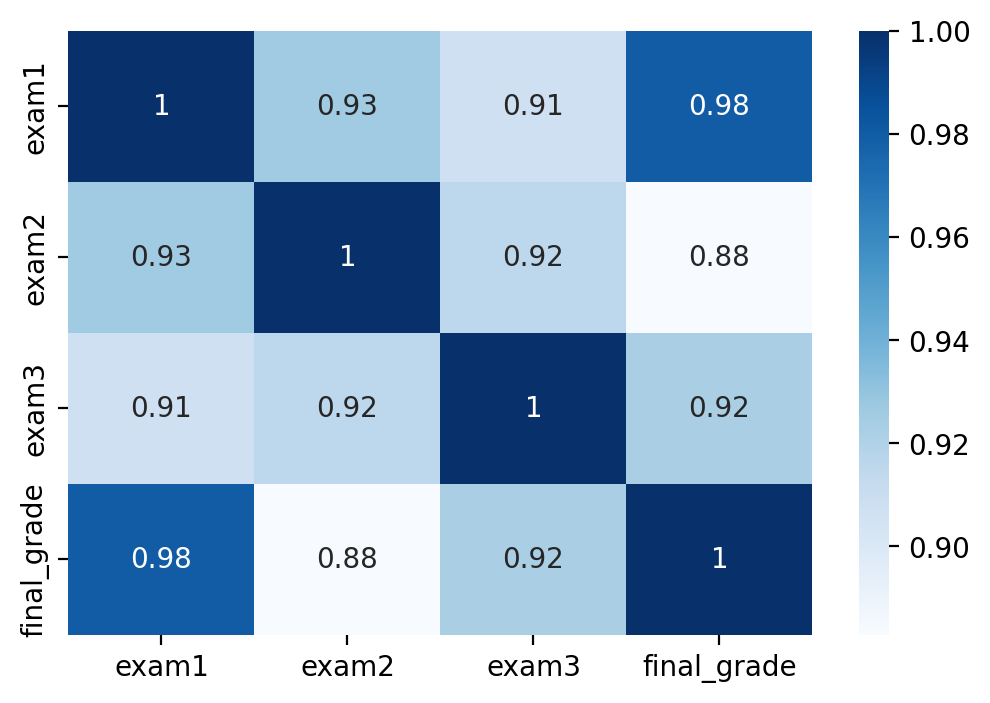

In [13]:
correlation_table = train.corr('spearman')
# sns.heatmap(correlation_table, cmap='Blues', annot=True, vmin=0, vmax=1)
sns.heatmap(correlation_table, cmap='Blues', annot=True)
plt.show()

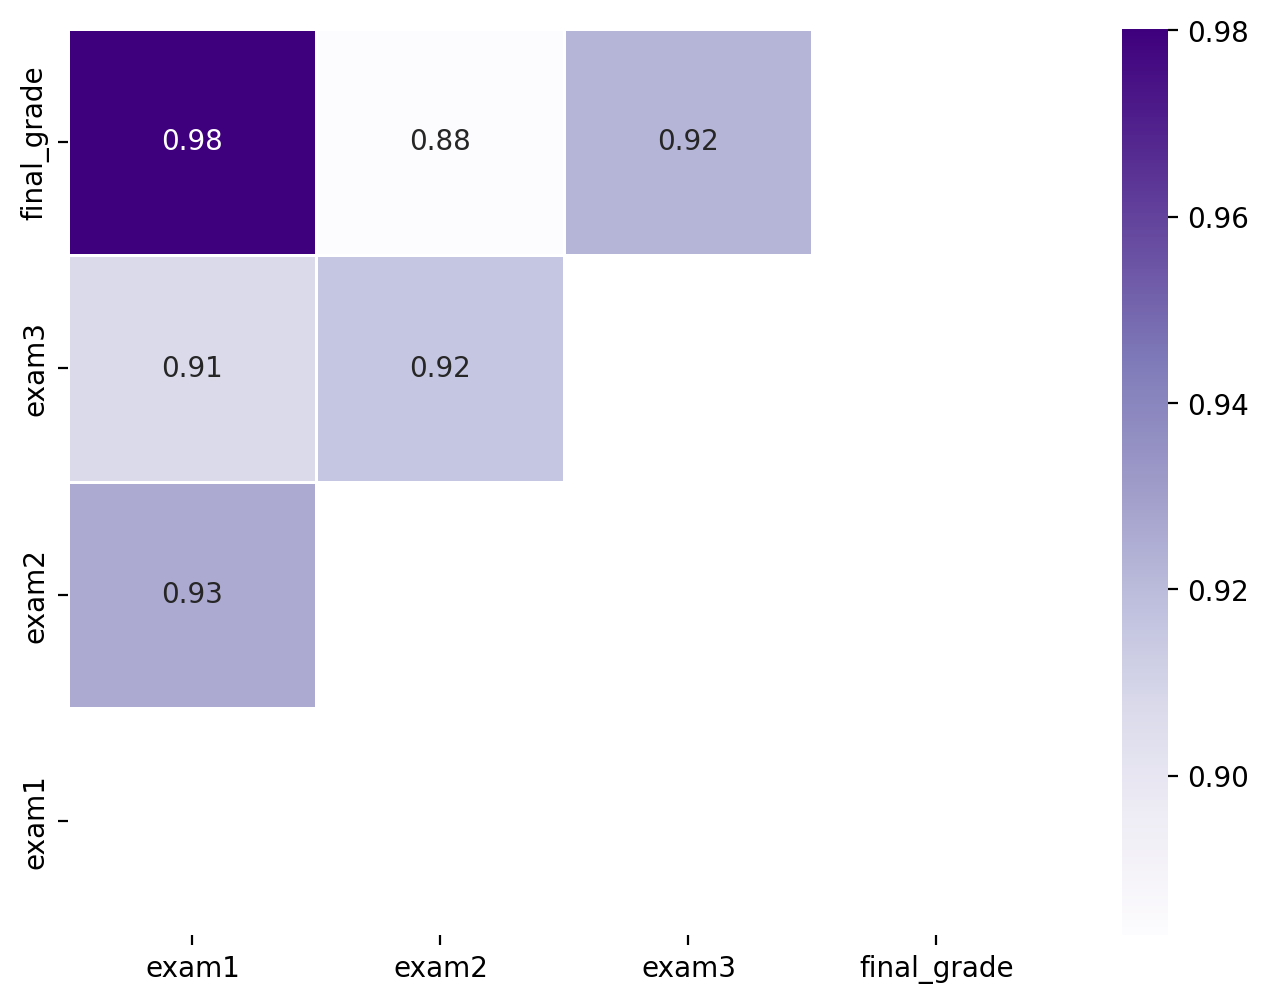

In [14]:
plt.figure(figsize=(8,6))
sns.heatmap(exam_corr, cmap='Purples', annot=True, linewidth=0.5, mask= np.triu(exam_corr))
plt.ylim(0, 4)

plt.show()

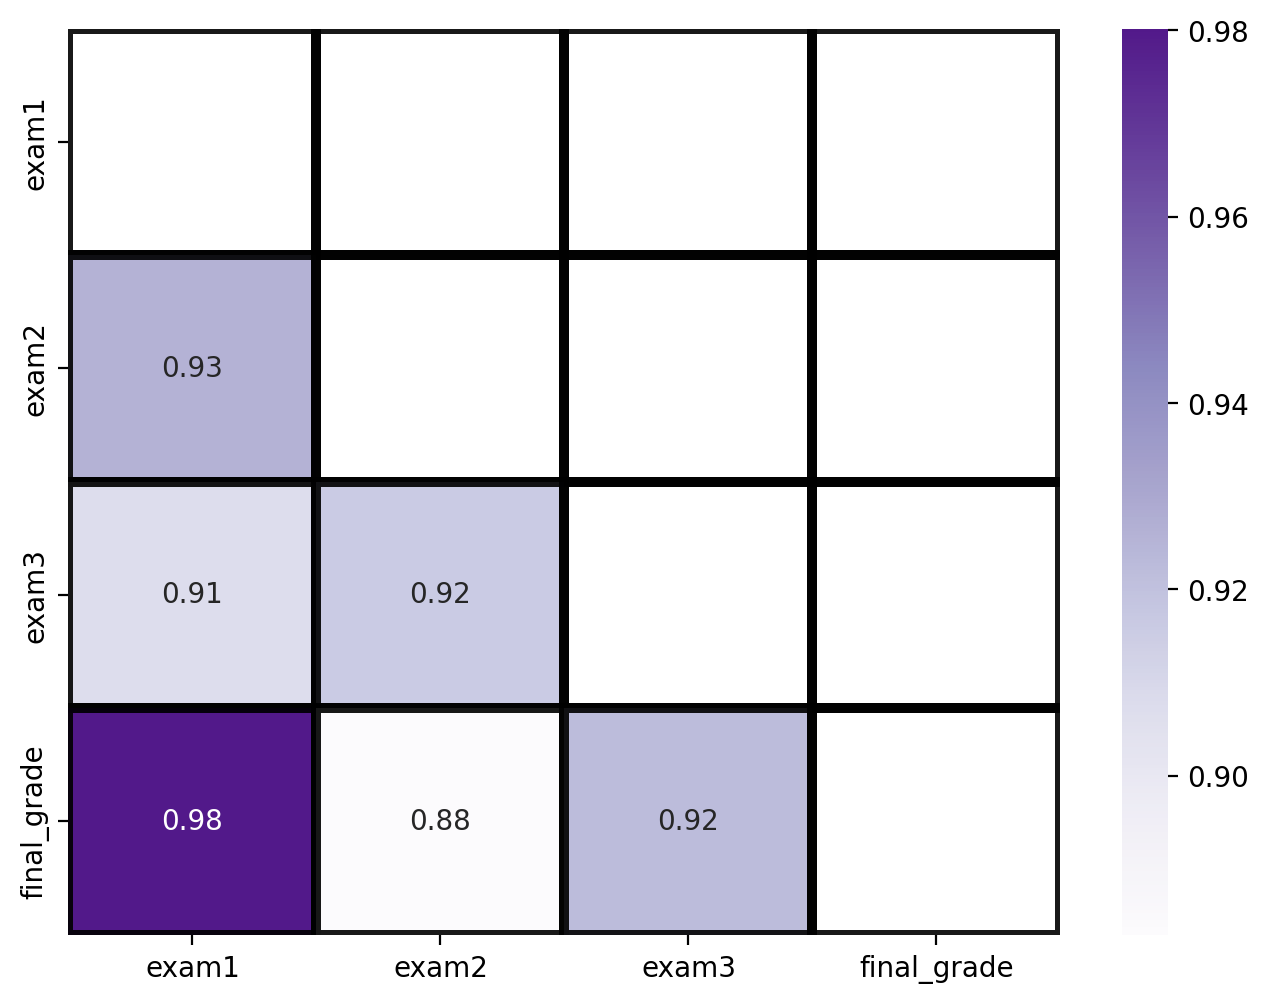

In [15]:
kwargs = {'alpha':.9,'linewidth':3, 'linestyle':'-', 
          'linecolor':'k','rasterized':False, 'edgecolor':'w', 
          'capstyle':'projecting',}

plt.figure(figsize=(8,6))
sns.heatmap(exam_corr, cmap='Purples', annot=True, mask= np.triu(exam_corr), **kwargs)

plt.show()

### Document Takeaways:

- Exam 1 seems to be the most predictive of final grade
- Everything seems to correlate with everything (Multicolinearity)

### Test Hypothesis(es)

In [16]:
# Use a scipy stats function pearsonr to calculate the correlation coefficient and the p-value.

r, p_value = pearsonr(train.exam1, train.final_grade)
print(f'Correlation Coefficient by Pearson Test: {r.round(4)}, p-value: {p_value.round(5)}')

# set alpha : 0.05
if p_value < 0.05:
    print('We can reject the null hypothesis')
else:
    print('we cannot reject the null hypothesis')

Correlation Coefficient by Pearson Test: 0.9841, p-value: 0.0
We can reject the null hypothesis


In [17]:
# Since my variables are not normally distributed, I should really choose Spearman instead.

r, p_value = spearmanr(train.exam1, train.final_grade)
print(f'Correlation Coefficient by Spearman Test: {r.round(4)}, p-value: {p_value.round(5)}')

# set alpha : 0.05
if p_value < 0.05:
    print('We can reject the null hypothesis')
else:
    print('we cannot reject the null hypothesis')

Correlation Coefficient by Spearman Test: 0.9802, p-value: 0.0
We can reject the null hypothesis


### What other kinds of visualizations could we have made?

### `sns.relplot()`

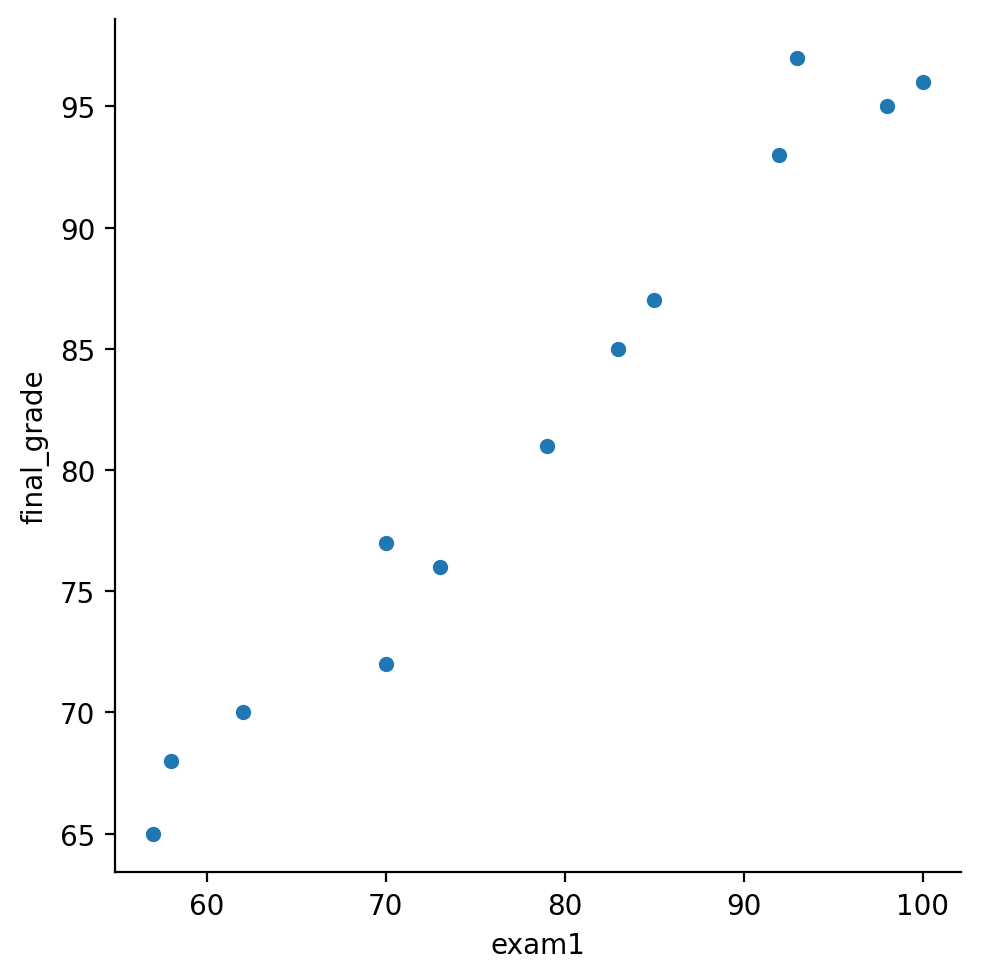

In [18]:
sns.relplot(x='exam1', y='final_grade', data=train)
plt.show()

### `sns.lmplot()`

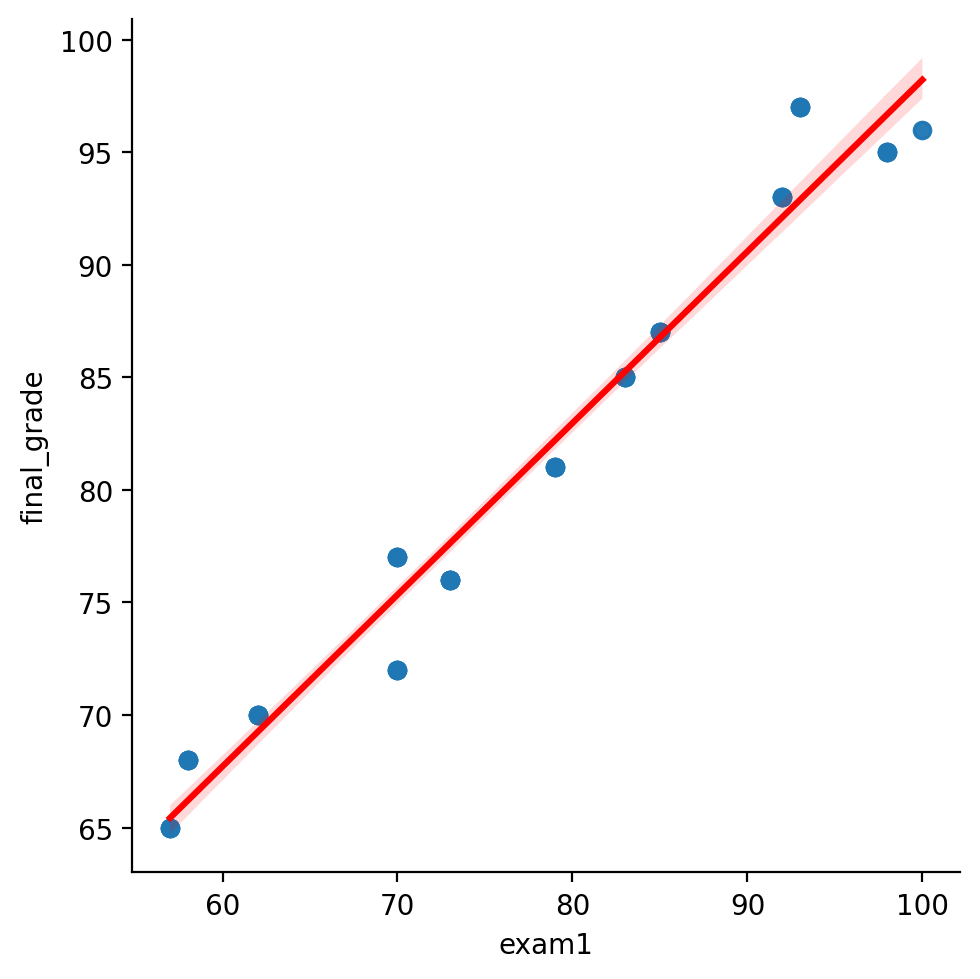

In [19]:
# I can really pop that line color if I want.
sns.lmplot(x='exam1', y='final_grade', data=train, line_kws={'color': 'red'})
plt.show()

### `sns.jointplot()`

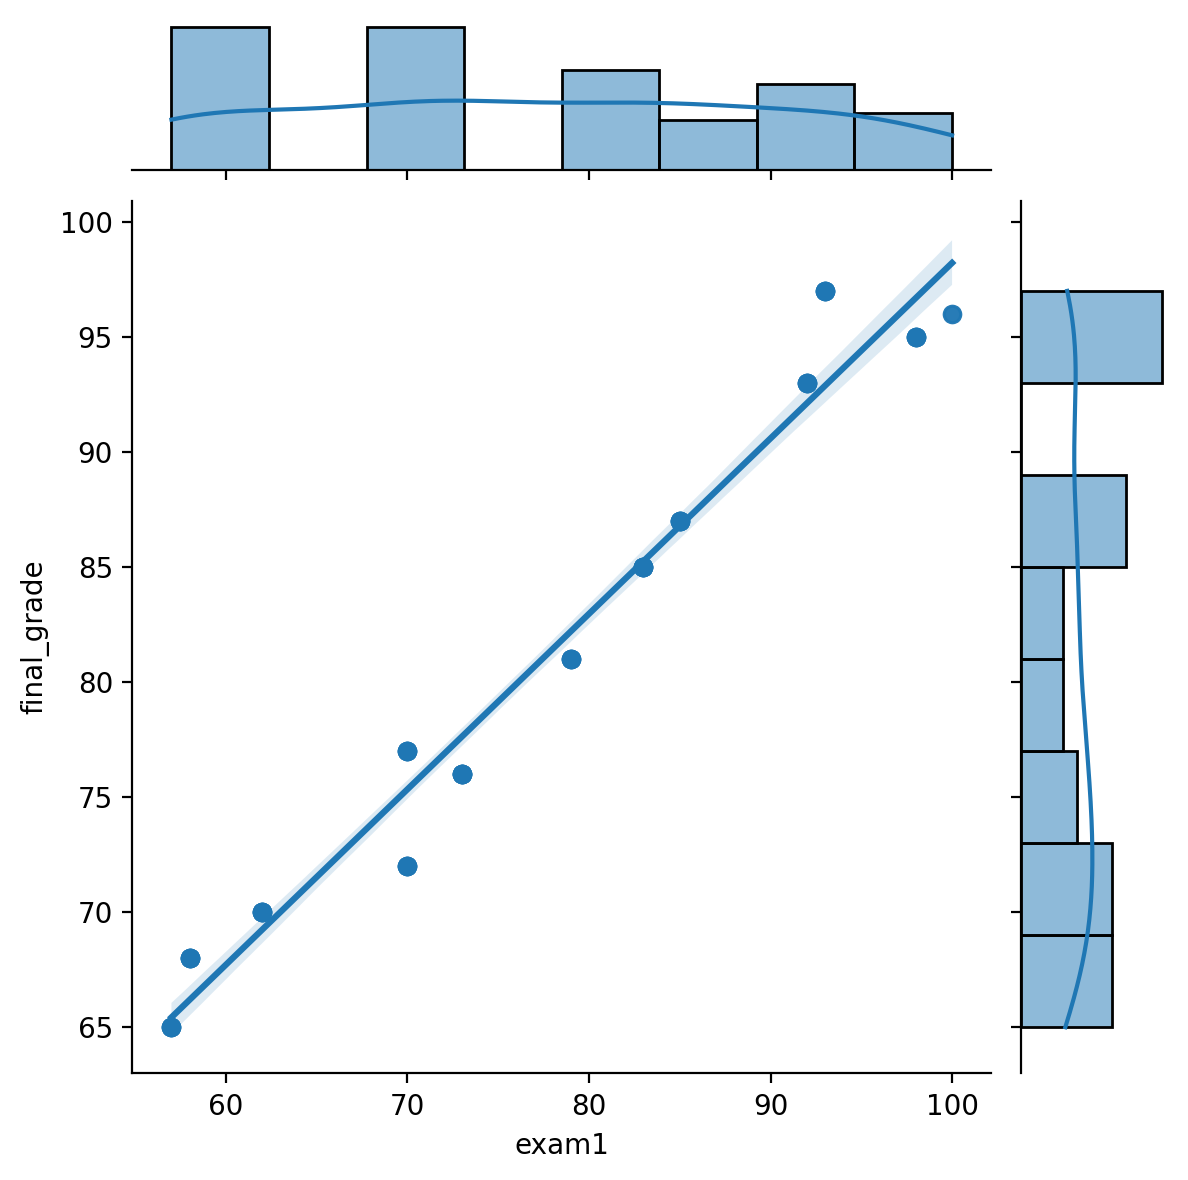

In [20]:
sns.jointplot(x='exam1', y='final_grade', data=train, kind='reg')
plt.show()

### `sns.pairplot()`

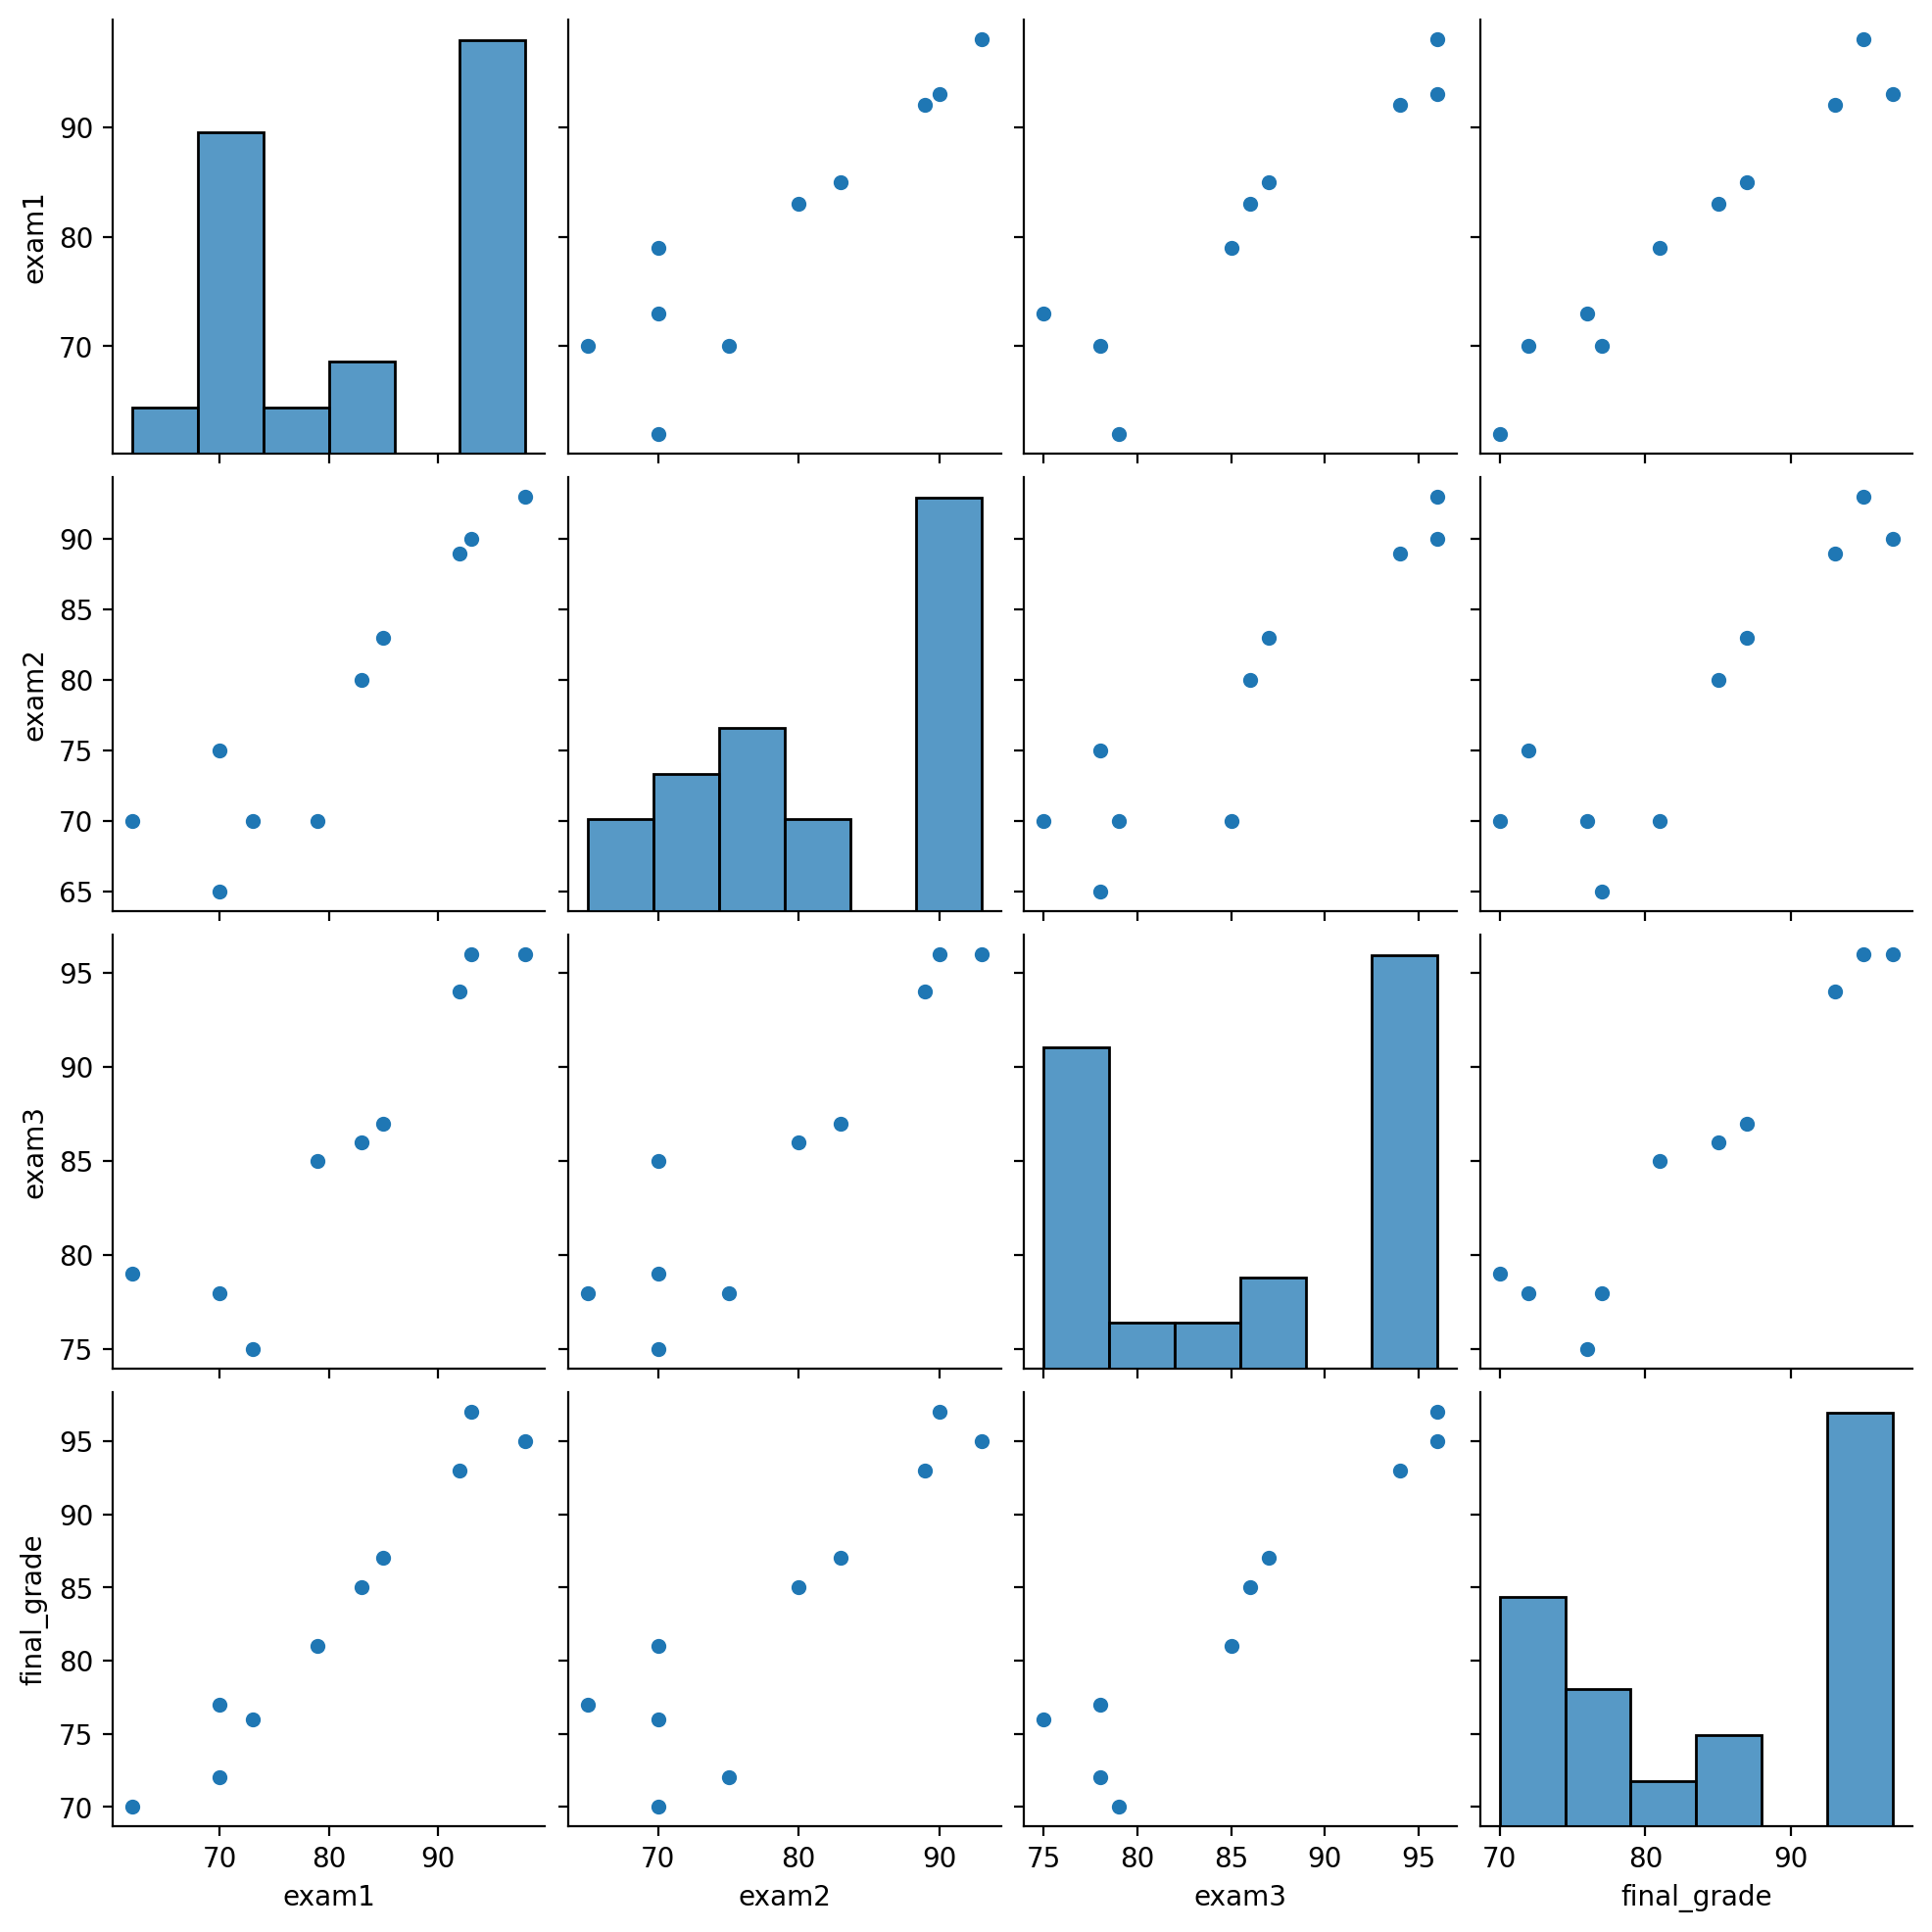

In [21]:
# do we have a really large dataset? (long)
sns.pairplot(train.sample(20))

In [22]:
train.sample(25)

,exam1,exam2,exam3,final_grade
63,57,65,75,65
32,92,89,94,93
55,83,80,86,85
28,85,83,87,87
85,73,70,75,76
15,85,83,87,87
66,98,93,96,95
14,98,93,96,95
71,92,89,94,93
3,83,80,86,85


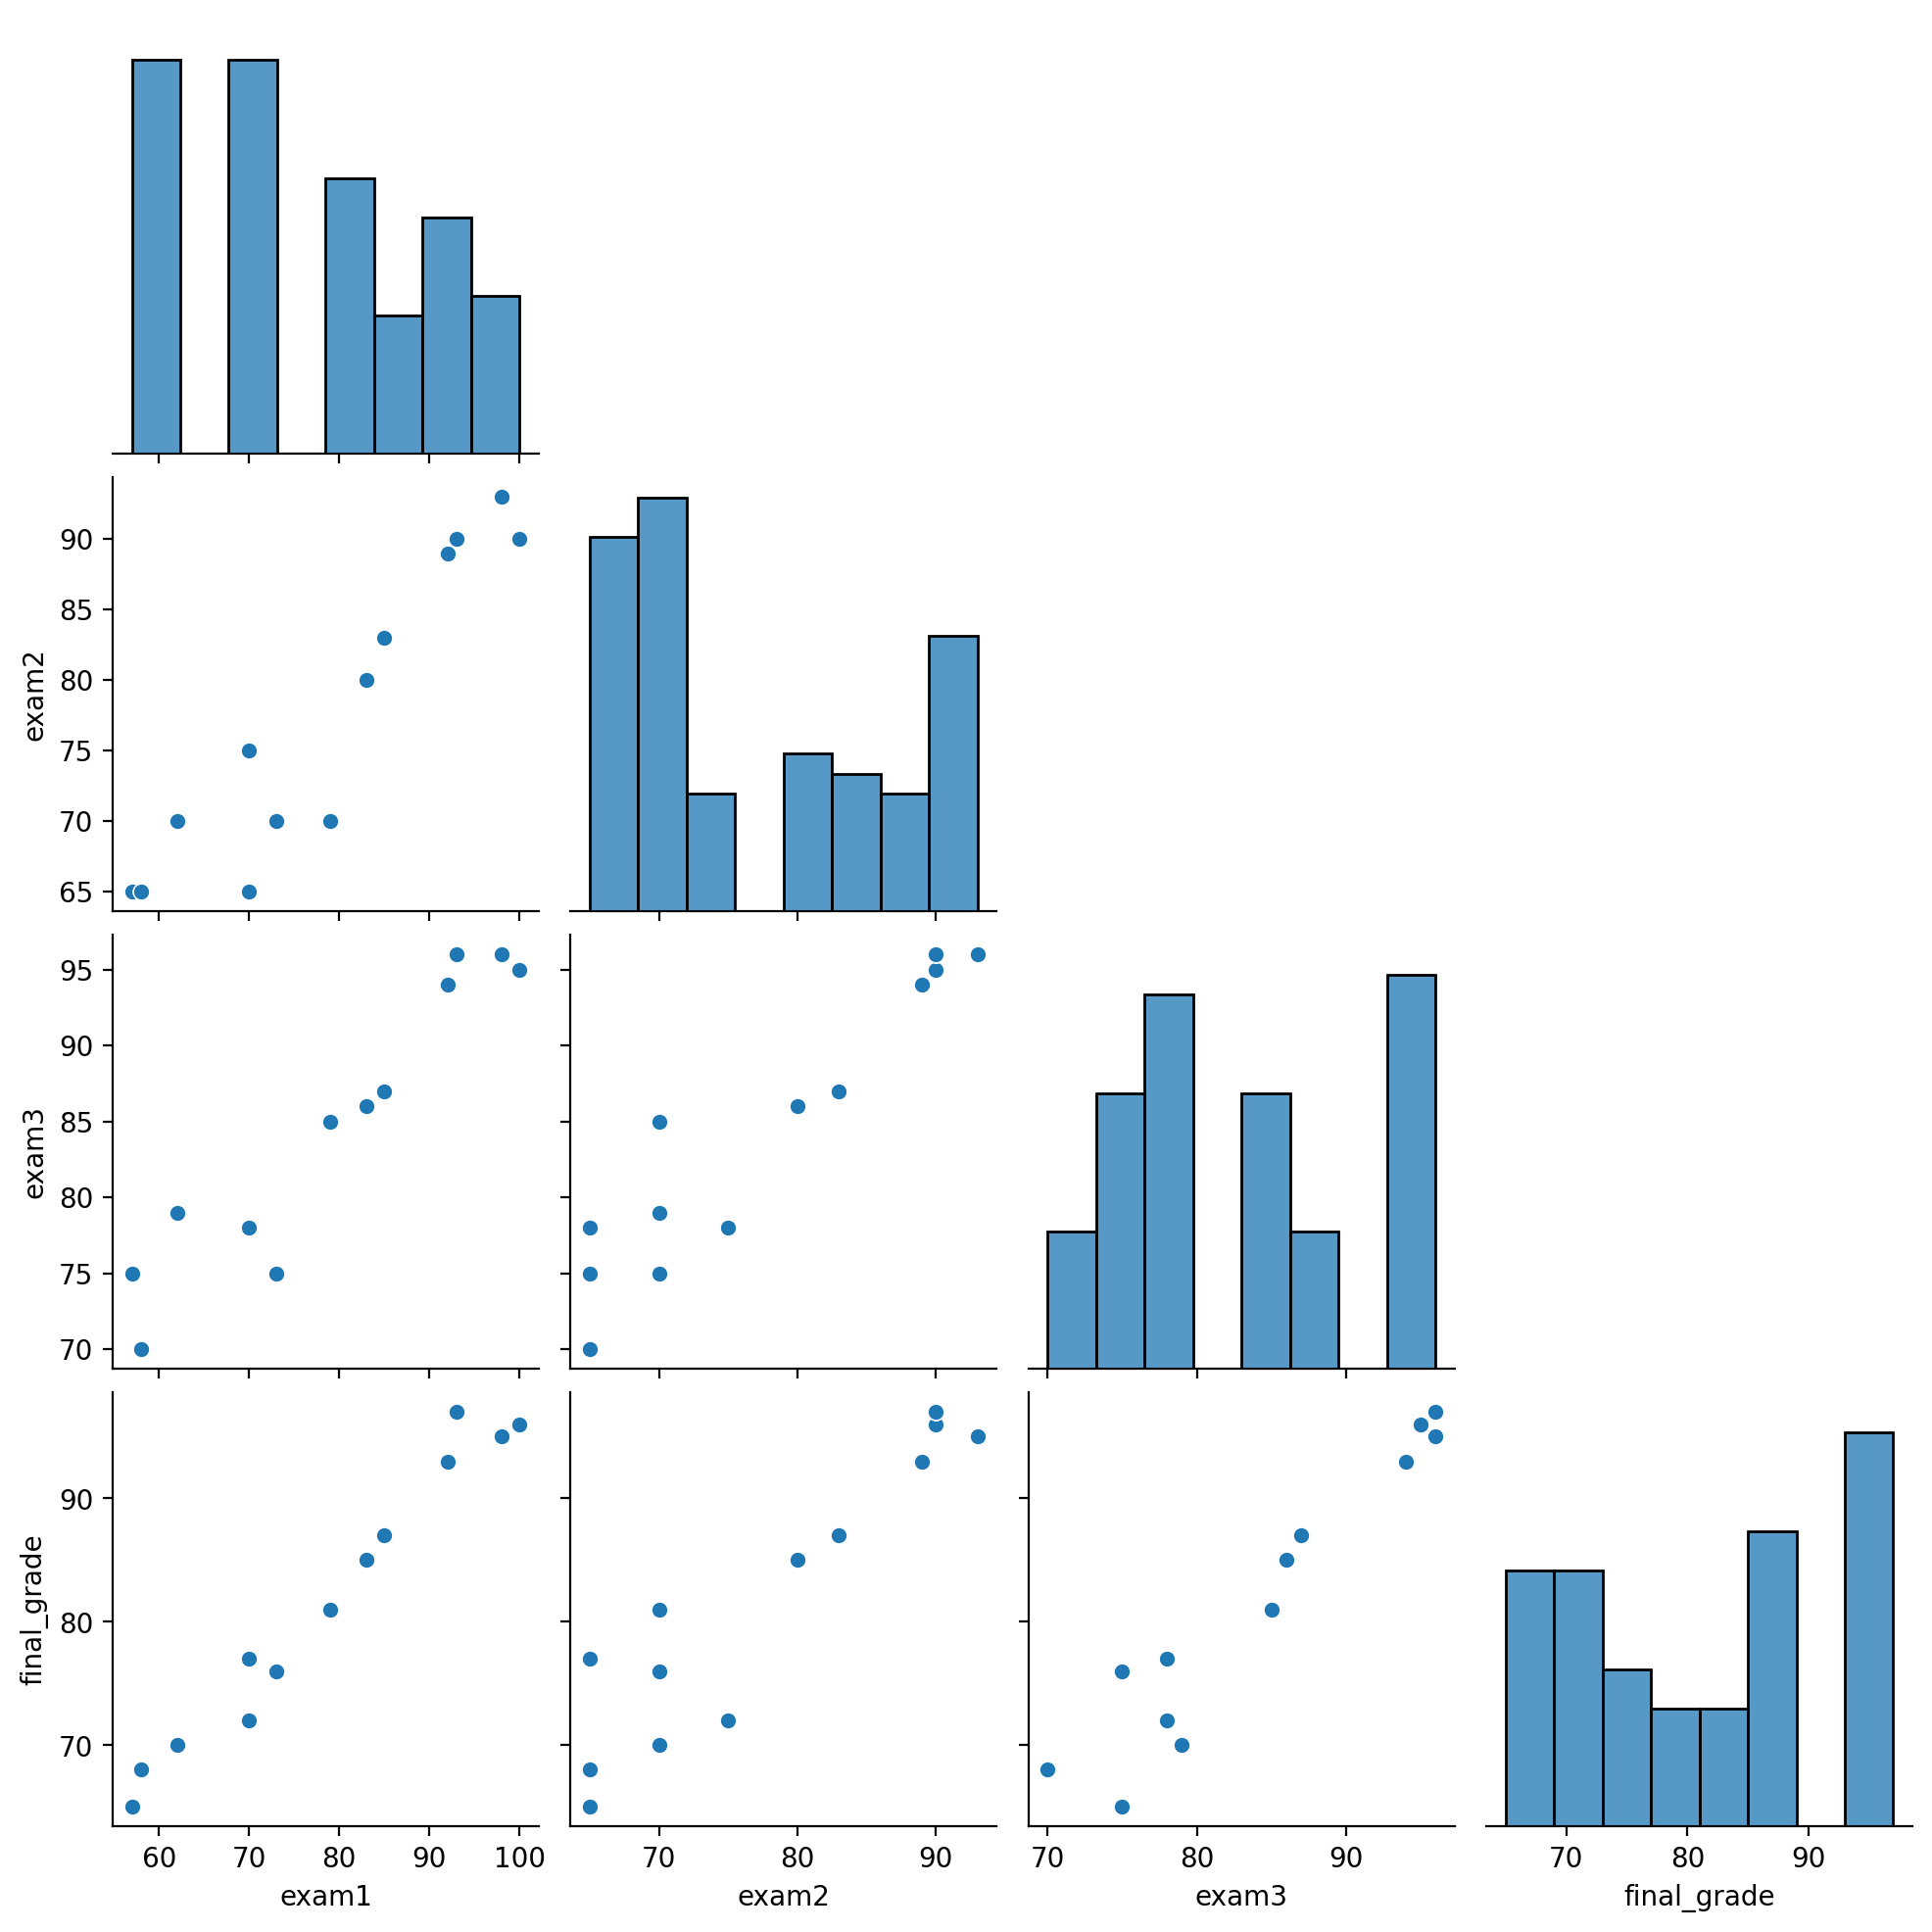

In [23]:
sns.pairplot(train, corner=True)
plt.savefig('somefile.png')

### Q2: Is there a cutoff in grade that makes sense to investigate? Passing/failing/letter grades?

In [24]:
train['exam1_desc'] = np.where(train.exam1 > 75, 'good grade', 'bad grade')
train['exam2_desc'] = np.where(train.exam2 > 75, 'good grade', 'bad grade')
train['exam3_desc'] = np.where(train.exam3 > 75, 'good grade', 'bad grade')

In [25]:
train

,exam1,exam2,exam3,final_grade,exam1_desc,exam2_desc,exam3_desc
86,70,65,78,77,bad grade,bad grade,good grade
21,70,65,78,77,bad grade,bad grade,good grade
31,79,70,85,81,good grade,bad grade,good grade
33,73,70,75,76,bad grade,bad grade,bad grade
102,57,65,75,65,bad grade,bad grade,bad grade
...,...,...,...,...,...,...,...
85,73,70,75,76,bad grade,bad grade,bad grade
19,92,89,94,93,good grade,good grade,good grade
100,62,70,79,70,bad grade,bad grade,good grade
94,83,80,86,85,good grade,good grade,good grade


<AxesSubplot:xlabel='final_grade', ylabel='Count'>

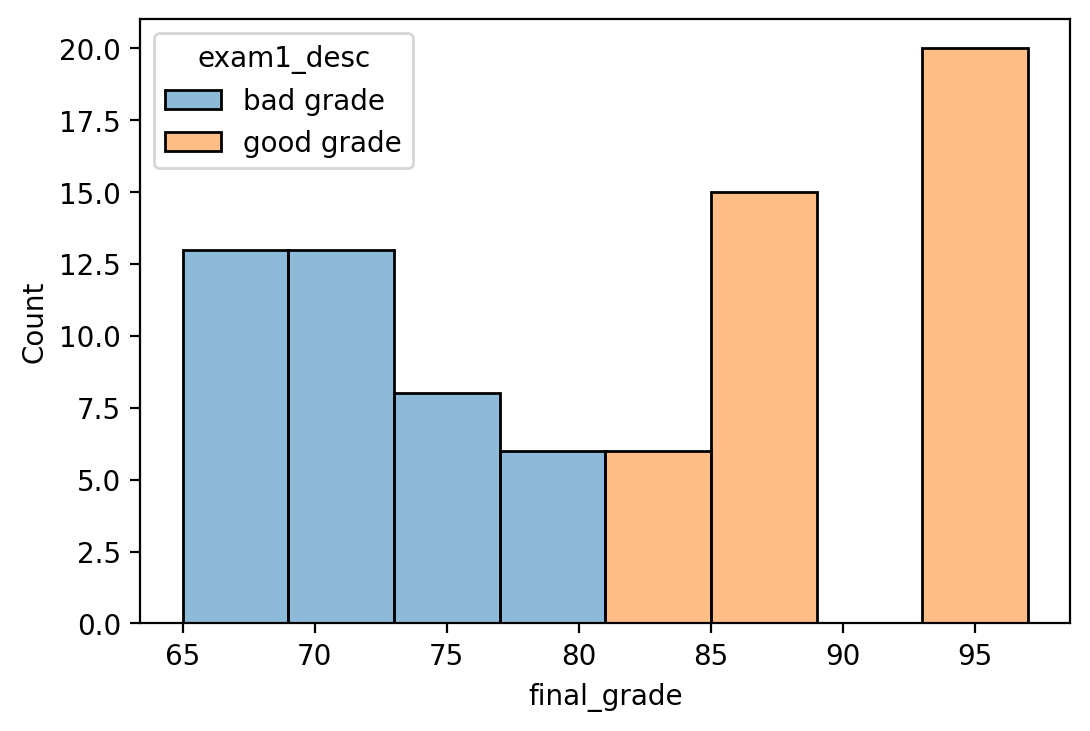

In [26]:
sns.histplot(data=train, x='final_grade', hue='exam1_desc', palette=['C0', 'C1'])

In [27]:
train.groupby('exam1_desc').final_grade.mean()

exam1_desc
bad grade     71.450000
good grade    89.682927
Name: final_grade, dtype: float64

<AxesSubplot:xlabel='final_grade', ylabel='Count'>

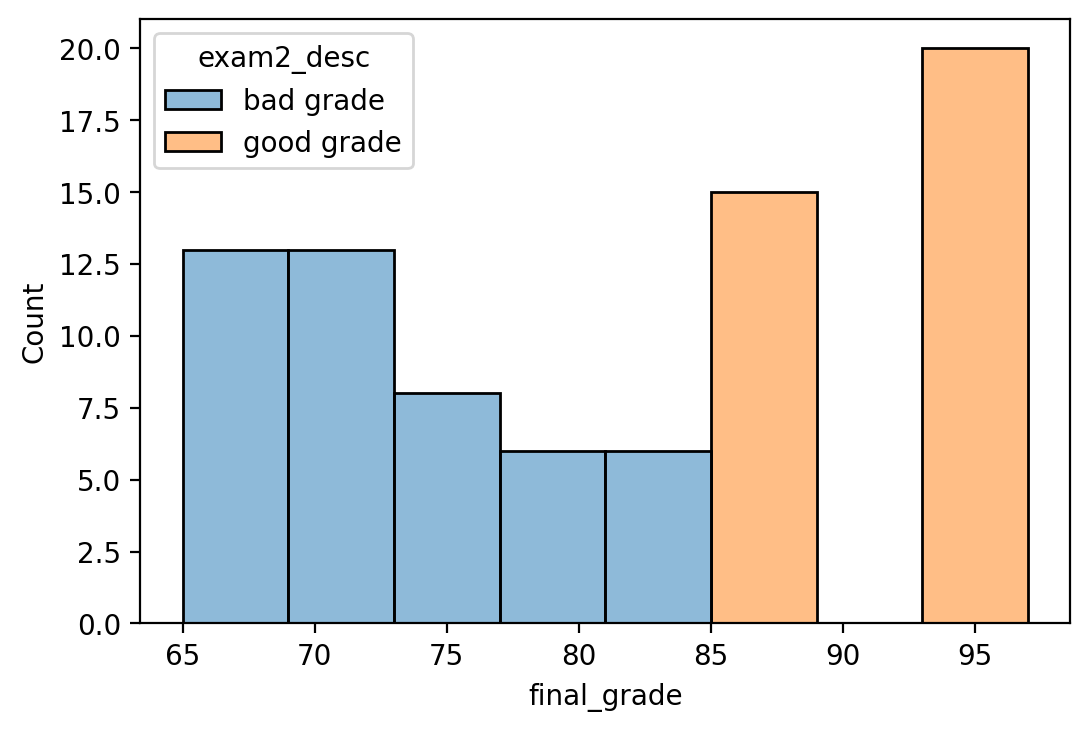

In [28]:
sns.histplot(data=train, x='final_grade', hue='exam2_desc', palette=['C0', 'C1'])

In [29]:
train.groupby('exam2_desc').final_grade.mean()

exam2_desc
bad grade     72.695652
good grade    91.171429
Name: final_grade, dtype: float64

<AxesSubplot:xlabel='final_grade', ylabel='Count'>

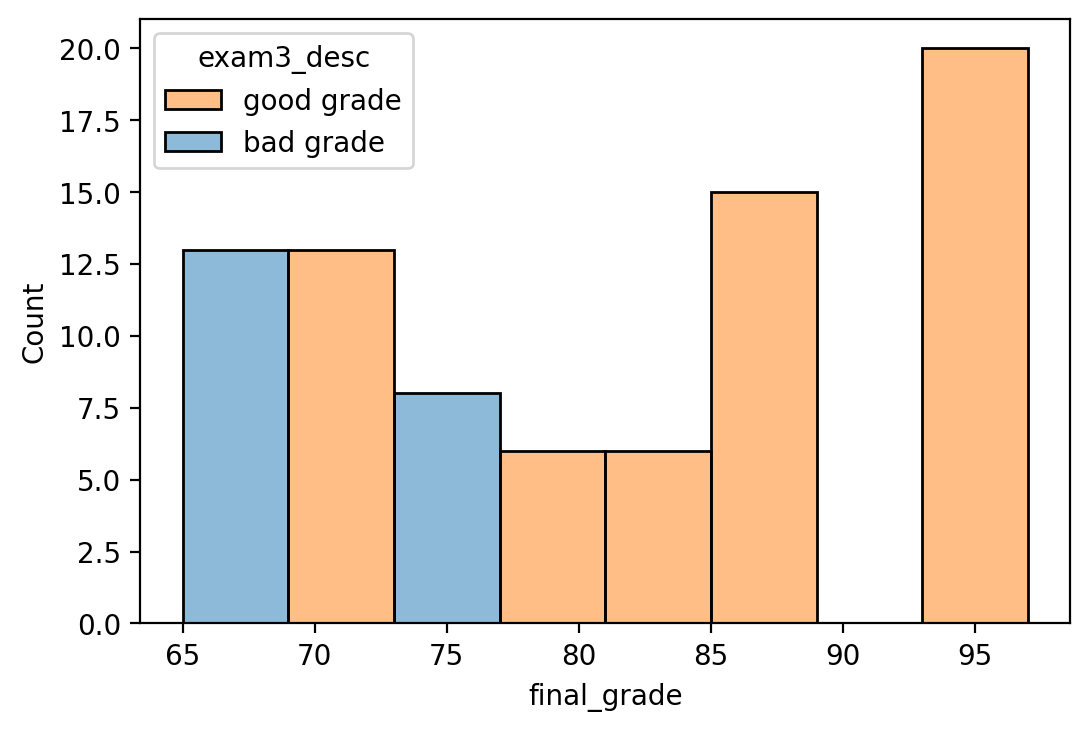

In [30]:
sns.histplot(data=train, x='final_grade', hue='exam3_desc', palette=['C1', 'C0'])

In [31]:
train.groupby('exam3_desc').final_grade.mean()

exam3_desc
bad grade     70.190476
good grade    84.350000
Name: final_grade, dtype: float64

### Takeaways
- People who made a good grade on exam1 and exam2 tend to make good final grades.
- exam3 is a little messier in its relationship with final_grade
- Given the multicollinearity present, we may want to just focus on one exam. 
- exam1 had the highest linear correlation in the correlation plot, so we can work with that one

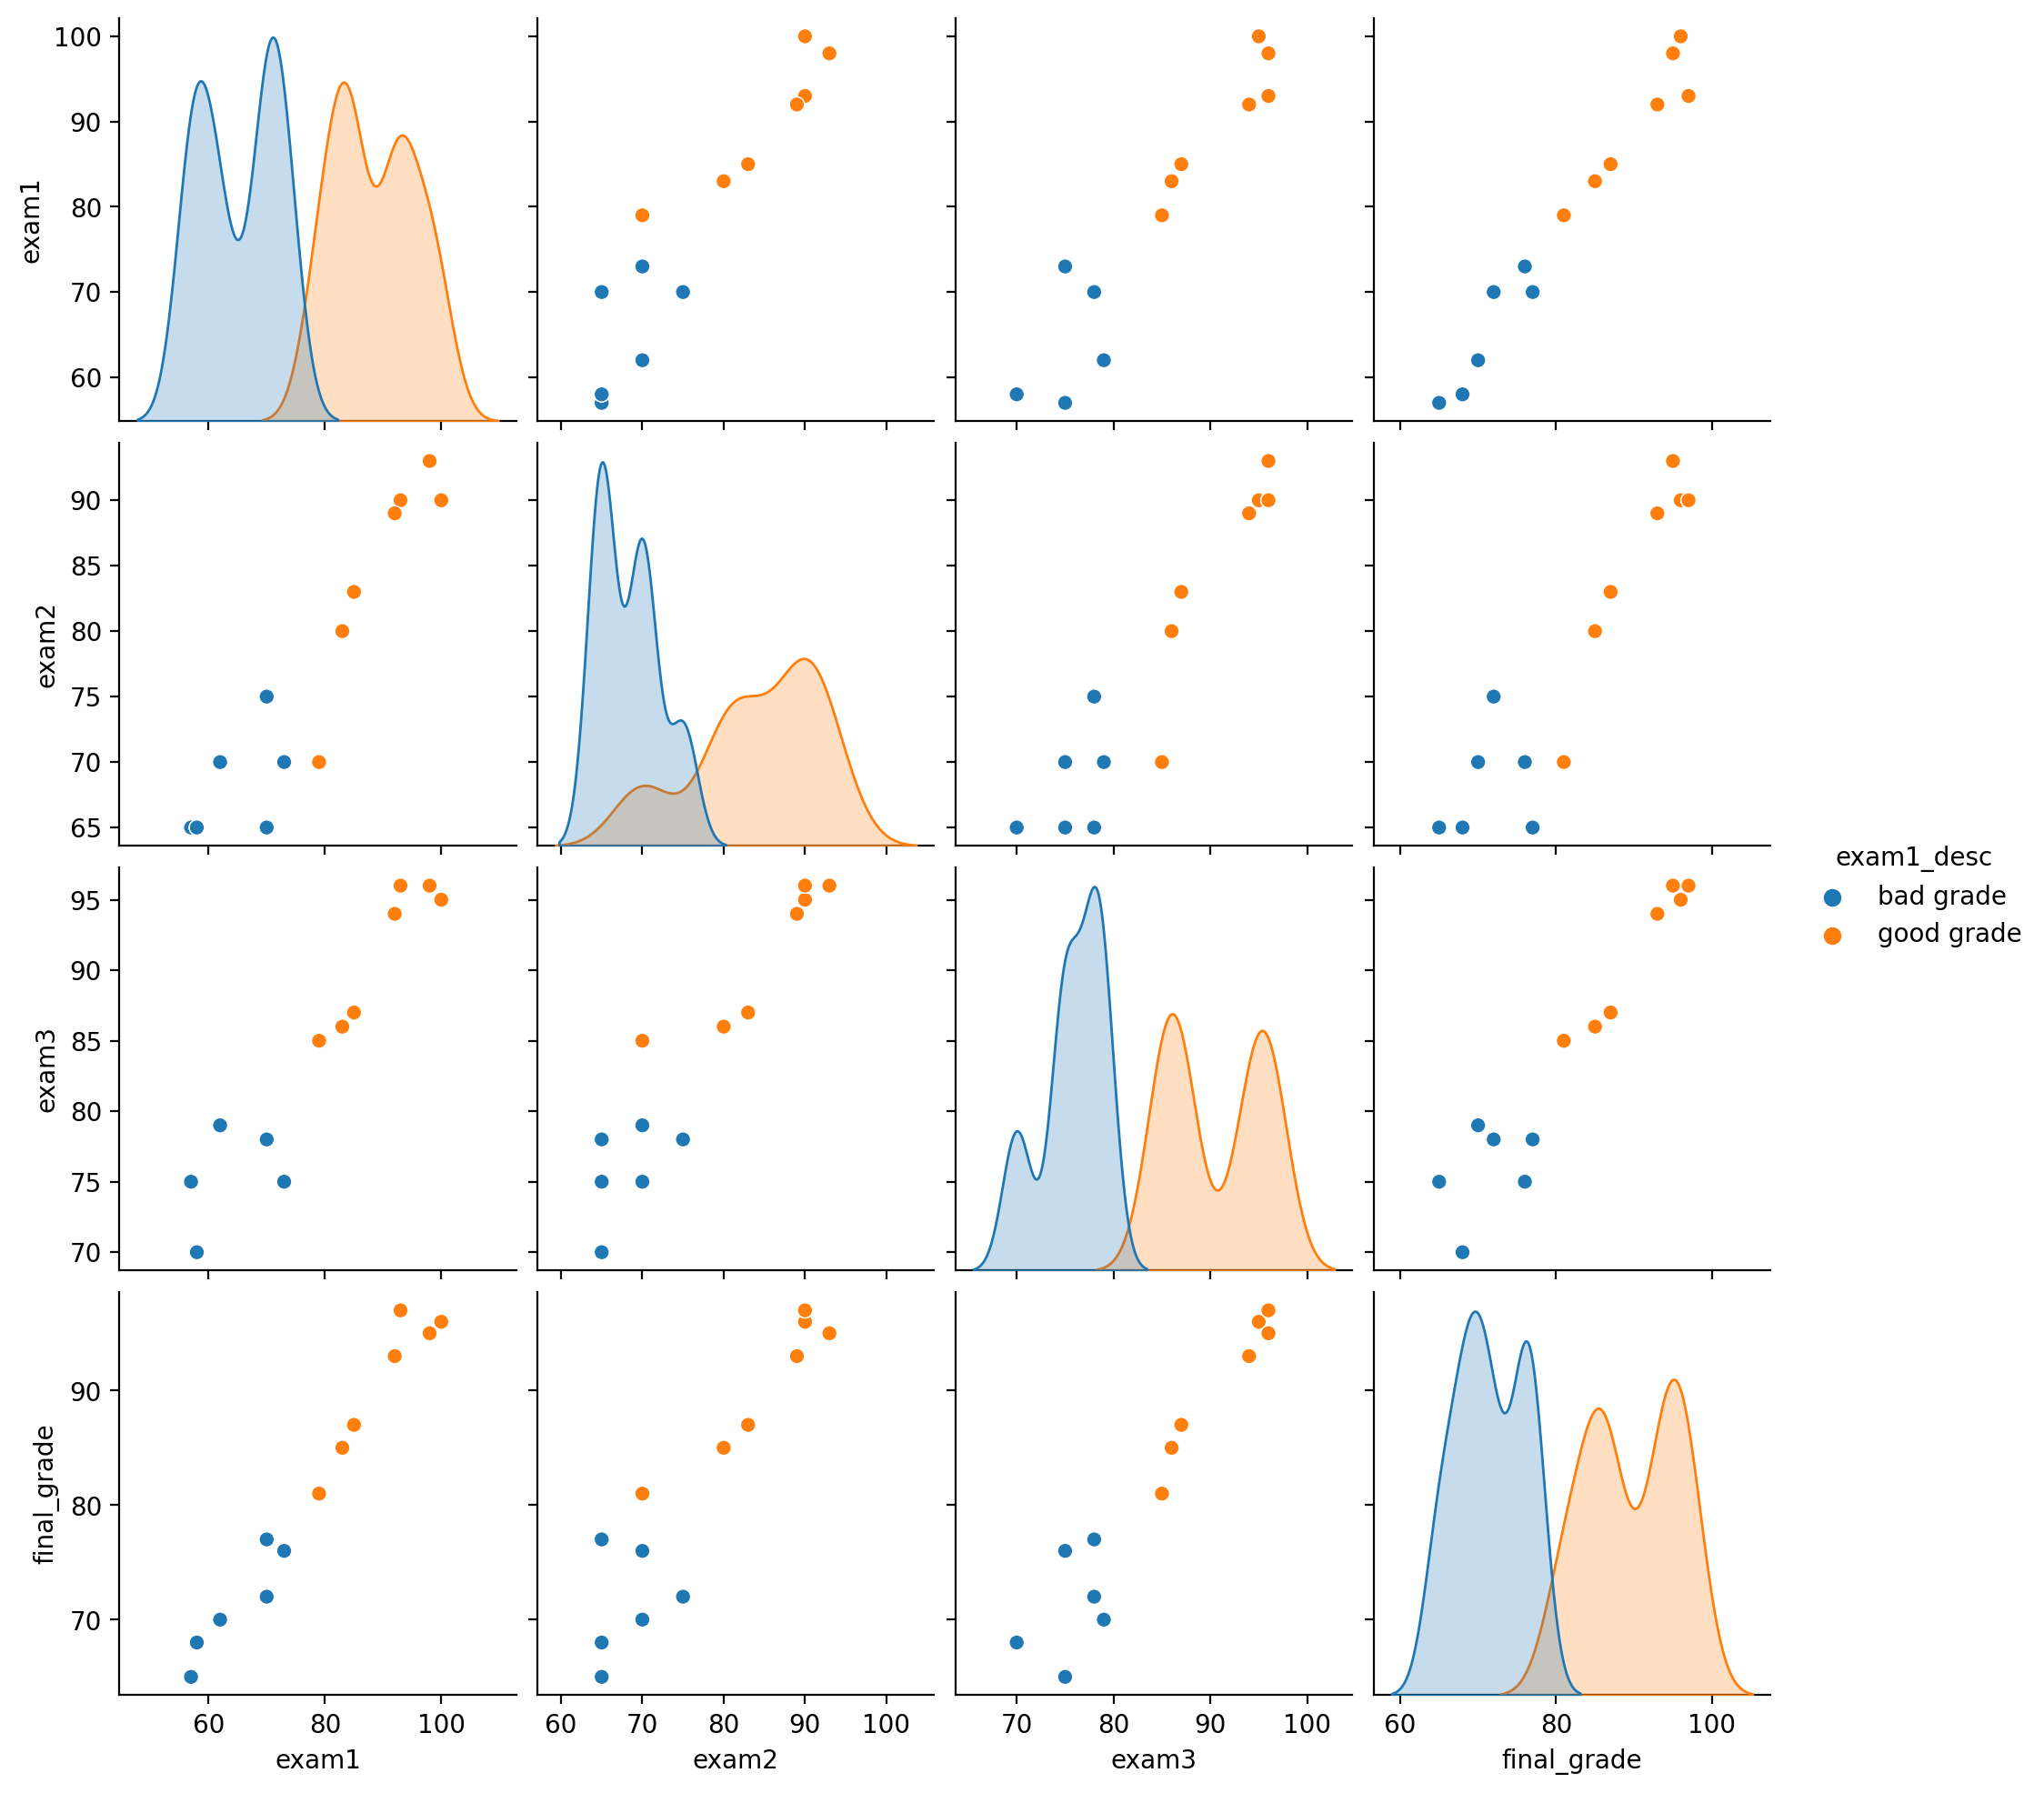

In [32]:
# Bonus visualization - Pairplots can also accept hue categories
sns.pairplot(train, hue='exam1_desc')

### Follow Up Question: How do people who eventually fail the class perform on exam1?

In [33]:
train['fails_class'] = train.final_grade < 75

In [34]:
pd.crosstab(train.exam1_desc, train.fails_class)

fails_class,False,True
exam1_desc,,
bad grade,14,26
good grade,41,0


Interesting. Everyone who made a good grade on exam1 (above a 75) passed the course.

In [35]:
pd.crosstab(train.exam1_desc, train.fails_class, normalize='index')

fails_class,False,True
exam1_desc,,
bad grade,0.35,0.65
good grade,1.00,0.00


Almost a third (32.5%) of students who get a bad grade (<=75) on the first exam end up failing the class.

We haven't even built a model yet and we already have an actionable recommendation. 